In [1]:
import cv2
import numpy as np
import os
import keras
from scipy.cluster.vq import kmeans2
from collections import Counter
import tensorflow as tf
import time
from PIL import Image 

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.keras.datasets.cifar100.load_data(label_mode='fine')
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

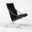

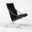

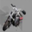

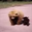

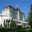

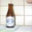

seconds elapsed:  95.46792507171631


In [3]:
def mse(targ, image):
    error = np.sum((targ.astype('float') - image.astype('float'))**2)
    error = error / float(targ.shape[0] * image.shape[1])
    return error


def build_tree(k, data):
    """
    recursively build KD-tree using keypoints / descriptors
    """
    descriptors = []
    des_dict = {}
    full_dict = {}

    sift = cv2.SIFT_create()

    for img in range(len(data)):
        kp, des = sift.detectAndCompute(data[img], None)
        count = 0
        
        if des is not None:
            full_dict[img] = des

            for d in des:
                des_dict[tuple(list(d))] = img
                descriptors.append(list(d))
                count += 1

    descriptors = np.array(descriptors)

    tree = KDT(k, descriptors, 0, des_dict, full_dict)

    return tree


def find_KNN(k, targ, tree, data):
    """
    find nearest neighbors of image 
    """
    count_dict = {}
    key_dict = {}
    des_dict = tree.des_dict
    full_dict = tree.full_dict

    sift = cv2.SIFT_create()

    for img in range(len(data)):
        kp = sift.detect(data[img], None)
        
        if kp is not None:
            key_dict[img] = kp

    _, targ_des = sift.detectAndCompute(targ, None)

    for img in range(len(data)):
            count_dict[img] = 0

    for img in range(len(targ_des)):
        des_found = tree.search(targ_des[img])
        
        for each in des_found:
            count_dict[des_dict[tuple(list(each))]] += 1

    k_neighbors = Counter(count_dict)
    k_neighbors.most_common()
    targ = Image.fromarray(targ, 'RGB')
    display(targ)
    
    for img, count in k_neighbors.most_common(k):
        found = Image.fromarray(data[img], 'RGB')
        display(found)


class KDT:
    
    def __init__(self, k, descriptors, depth, des_dict, full_dict):
        self.head = kdTree(k, descriptors, depth)
        self.des_dict = des_dict
        self.full_dict = full_dict

    def search(self,descriptor):
        return self.head.search(descriptor)

    def des_dict(self):
        return des_dict

    def full_dict(self):
        return full_dict

    
class kdTree:
    
    def __init__(self, k, descriptors, depth):
        self.descriptors = descriptors
        self.data = []
        self.children = []
        self.leaf = False
        
        if len(descriptors) >= k:
            self.data, labels = kmeans2(descriptors, k, minit='points')
            
            for i in range(0, k):
                ret = []
                
                for j in range(0, len(labels)):
                    if i == labels[j]:
                        ret.append(descriptors[j])
                ret = np.array(ret)
                
                if len(ret) > 0:
                    self.children.append(kdTree(k, ret, depth + 1))
        else:
            self.data = descriptors
            self.leaf = True
            
            
    def search(self, descriptor):
        if self.leaf:
            return self.data
        
        curr = np.linalg.norm(np.array(descriptor) - np.array(self.data[0]))
        track = 0
        
        for img in range(1, len(self.data)):
            dist = np.linalg.norm(np.array(descriptor) - np.array(self.data[img]))
            
            if dist < curr:
                curr = dist
                track = img
                
        return self.children[track].search(descriptor)

    
if __name__ == "__main__":
    
    k = 5
    start = time.time()
    kd_tree = build_tree(k, x_train)
    find_KNN(k, x_train[5231], kd_tree, x_train)
    end = time.time()
    print('seconds elapsed: ', end - start)